In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input, Dense, Flatten
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def normalize(image, label):
  '''Normalizes the image. Returns image as input and label.'''
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0

  return image, label

def map_image(image, label):
  return image, image

def map_image_with_noise(image, label):
  noise_factor = 0.5
  factor = noise_factor * tf.random.normal(shape=image.shape)
  image_noisy = image + factor
  image_noisy = tf.clip_by_value(image_noisy, 0.0, 1.0)
 
  return image_noisy, label
  
def map_image_with_noise_encoder(image, label):
  noise_factor = 0.5
  factor = noise_factor * tf.random.normal(shape=image.shape)
  image_noisy = image + factor
  image_noisy = tf.clip_by_value(image_noisy, 0.0, 1.0)
 
  return image_noisy, image

In [3]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(normalize)

train_dataset_encoder = train_dataset.map(map_image_with_noise_encoder)

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset_encoder = train_dataset_encoder.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('mnist', as_supervised=True, split="test")
test_dataset = test_dataset.map(normalize)
test_dataset_noise = test_dataset.map(map_image_with_noise)

test_dataset_encoder = test_dataset.map(map_image_with_noise_encoder)

test_dataset = test_dataset.batch(BATCH_SIZE).repeat()
test_dataset_noise = test_dataset_noise.batch(10000).repeat()
test_dataset_encoder = test_dataset_encoder.batch(BATCH_SIZE).repeat()

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


<img src="https://drive.google.com/uc?export=view&id=15zh7bst9KKvciRdCvMAH7kXt3nNkABzO" width="75%" height="75%"/>

In [4]:
def encoder(inputs):
  '''Defines the encoder with two Conv2D and max pooling layers.'''
  conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(max_pool_1)
  max_pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_2)

  return max_pool_2

In [5]:
def bottle_neck(inputs):
  '''Defines the bottleneck.'''
  bottle_neck = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  encoder_visualization = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(bottle_neck)

  return bottle_neck, encoder_visualization

In [6]:
def decoder(inputs):
  '''Defines the decoder path to upsample back to the original image size.'''
  conv_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  up_sample_1 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(up_sample_1)
  up_sample_2 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_2)

  conv_3 = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(up_sample_2)

  return conv_3

In [7]:
def convolutional_auto_encoder():
  '''Builds the entire autoencoder model.'''
  inputs = tf.keras.layers.Input(shape=(28, 28, 1,))
  encoder_output = encoder(inputs)
  bottleneck_output, encoder_visualization = bottle_neck(encoder_output)
  decoder_output = decoder(bottleneck_output)
  
  autoencoder_model = tf.keras.Model(inputs =inputs, outputs=decoder_output)
  encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_visualization)
  return autoencoder_model, encoder_model

In [8]:
conv_autoencoder_model, convolutional_encoder_model = convolutional_auto_encoder()
conv_autoencoder_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 256)         295168

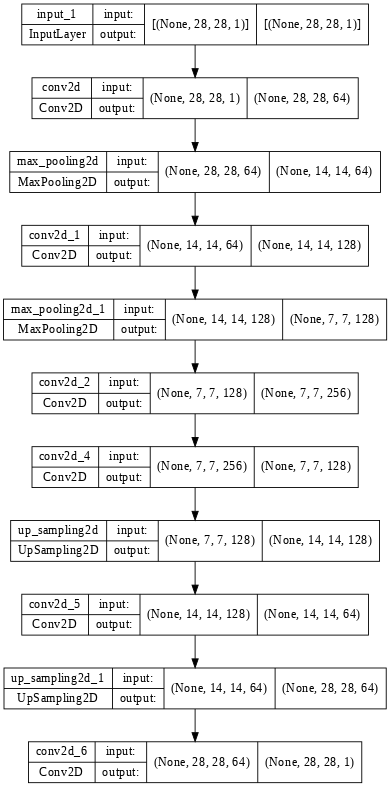

In [9]:
tf.keras.utils.plot_model(conv_autoencoder_model, show_shapes=True, dpi=64)

In [10]:
type(train_dataset_encoder)

tensorflow.python.data.ops.dataset_ops.RepeatDataset

In [11]:
train_steps = 60000 // BATCH_SIZE
epochs=50

with tf.device('/device:GPU:0'):
  conv_autoencoder_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy')
  autoencoder_history = conv_autoencoder_model.fit(train_dataset_encoder, steps_per_epoch=train_steps, epochs=epochs)

Epoch 1/50
468/468 [==============================] - 27s 31ms/step - loss: 0.1373
Epoch 2/50
468/468 [==============================] - 13s 27ms/step - loss: 0.1006
Epoch 3/50
468/468 [==============================] - 13s 27ms/step - loss: 0.0974
Epoch 4/50
468/468 [==============================] - 13s 27ms/step - loss: 0.0955
Epoch 5/50
468/468 [==============================] - 13s 28ms/step - loss: 0.0944
Epoch 6/50
468/468 [==============================] - 13s 28ms/step - loss: 0.0934
Epoch 7/50
468/468 [==============================] - 13s 27ms/step - loss: 0.0928
Epoch 8/50
468/468 [==============================] - 13s 27ms/step - loss: 0.0921
Epoch 9/50
468/468 [==============================] - 12s 27ms/step - loss: 0.0918
Epoch 10/50
468/468 [==============================] - 13s 28ms/step - loss: 0.0913
Epoch 11/50
468/468 [==============================] - 13s 27ms/step - loss: 0.0910
Epoch 12/50
468/468 [==============================] - 12s 27ms/step - loss: 0.0906
E

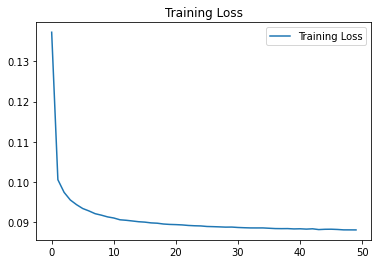

In [12]:
loss = autoencoder_history.history['loss']

epochs_range = range(epochs)

plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

Display results of autoencoder

In [13]:
def display_one_row(disp_images, offset, shape=(28, 28), title=''):
  '''Display sample outputs in one row.'''
  for idx, image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    image = np.reshape(image, shape)
    plt.title(title)
    plt.imshow(image, cmap='gray')


def display_results(original_images, noisy_images, denoised_images, enc_shape=(8,4)):
  '''Displays the input, encoded, and decoded output values.'''
  plt.figure(figsize=(20, 5))
  display_one_row(original_images, 0, shape=(28,28,), title='Original')
  display_one_row(noisy_images, 10, shape=(28,28,), title='Noisy')
  display_one_row(denoised_images, 20, shape=(28,28,), title='Denoised')

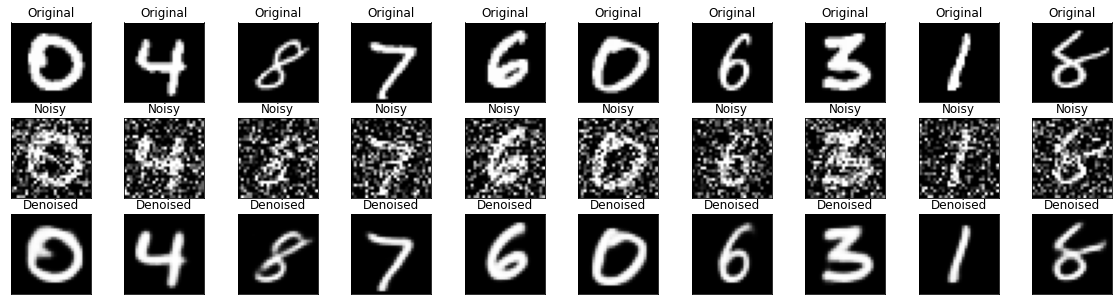

In [14]:
# take 1 batch of the dataset
test_dataset_encoder_show = test_dataset_encoder.take(1)
test_dataset_show = test_dataset.take(1)

# take the input images and put them in a list
noisy_images = []
original_images = []
for noisy_image, original_image in tfds.as_numpy(test_dataset_encoder_show):
      noisy_images = noisy_image
      original_images = original_image

# pick 10 indices
idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# prepare test samples with noise as a batch of 10 images
noisy_images_sample = np.array(noisy_images[idxs])
noisy_images_sample = np.reshape(noisy_images_sample, (10, 28, 28, 1))

# prepare test samples as a batch of 10 images
original_images_sample = np.array(original_images[idxs])
original_images_sample = np.reshape(original_images_sample, (10, 28, 28, 1))

# get a prediction for some values in the dataset
denoised_images = conv_autoencoder_model.predict(noisy_images_sample)

# display the samples, encodings and decoded values!
display_results(original_images_sample, noisy_images_sample, denoised_images, enc_shape=(7,7))

Build simple dense classifier NN

In [15]:
def simple_classifier():
  '''Builds the entire MNIST classifier model.'''
  inputs = Input(shape=(28, 28, 1,))
  x = Flatten()(inputs)
  x = Dense(512, activation="relu")(x)
  outputs = Dense(10, activation="softmax")(x)
  classifier_model = tf.keras.Model(inputs =inputs, outputs=outputs)
  return classifier_model

In [16]:
classifier_model = simple_classifier()

In [17]:
classifier_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


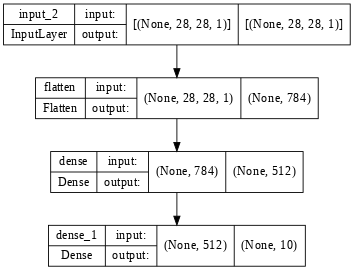

In [18]:
tf.keras.utils.plot_model(classifier_model, show_shapes=True, dpi=64)

In [19]:
classifier_model.compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])


In [20]:
train_steps = 60000 // BATCH_SIZE
valid_steps = 10000 // BATCH_SIZE
classifier_epochs=10
classifier_history = classifier_model.fit(train_dataset, steps_per_epoch=train_steps, validation_data=test_dataset, validation_steps=valid_steps, epochs=classifier_epochs)

Epoch 1/10
468/468 [==============================] - 4s 6ms/step - loss: 0.2563 - accuracy: 0.9258 - val_loss: 0.1264 - val_accuracy: 0.9627
Epoch 2/10
468/468 [==============================] - 3s 5ms/step - loss: 0.1043 - accuracy: 0.9693 - val_loss: 0.0902 - val_accuracy: 0.9735
Epoch 3/10
468/468 [==============================] - 3s 5ms/step - loss: 0.0687 - accuracy: 0.9798 - val_loss: 0.0755 - val_accuracy: 0.9764
Epoch 4/10
468/468 [==============================] - 3s 6ms/step - loss: 0.0498 - accuracy: 0.9854 - val_loss: 0.0754 - val_accuracy: 0.9769
Epoch 5/10
468/468 [==============================] - 3s 6ms/step - loss: 0.0364 - accuracy: 0.9894 - val_loss: 0.0748 - val_accuracy: 0.9772
Epoch 6/10
468/468 [==============================] - 3s 6ms/step - loss: 0.0280 - accuracy: 0.9918 - val_loss: 0.0696 - val_accuracy: 0.9793
Epoch 7/10
468/468 [==============================] - 3s 6ms/step - loss: 0.0216 - accuracy: 0.9937 - val_loss: 0.0727 - val_accuracy: 0.9795
Epoch 

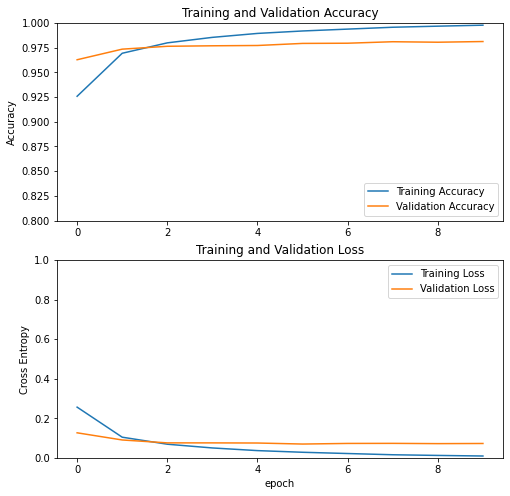

In [21]:
acc = classifier_history.history['accuracy']
val_acc = classifier_history.history['val_accuracy']

loss = classifier_history.history['loss']
val_loss = classifier_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
orig_test_loss, orig_test_acc = classifier_model.evaluate(test_dataset, steps=valid_steps)
print("Original images validation accuracy: {:.4f}".format(orig_test_acc))
print("Original images validation loss: {:.4f}".format(orig_test_loss))

78/78 [==============================] - 0s 3ms/step - loss: 0.0724 - accuracy: 0.9812
Original images validation accuracy: 0.9812
Original images validation loss: 0.0724


In [23]:
noisy_test_loss, noisy_test_acc = classifier_model.evaluate(test_dataset_noise, steps=valid_steps)
print("Noisy images validation accuracy: {:.4f}".format(noisy_test_acc))
print("Noisy images validation loss: {:.4f}".format(noisy_test_loss))

78/78 [==============================] - 67s 863ms/step - loss: 16.4949 - accuracy: 0.2917
Noisy images validation accuracy: 0.2917
Noisy images validation loss: 16.4949


In [24]:
# take 10000 items from noisy dataset
noisy_data = test_dataset_noise.take(1)

# take the input images and put them in a list
noisy_images = []
noisy_labels = []
for noisy_image, label in tfds.as_numpy(noisy_data):
      noisy_images = noisy_image
      noisy_labels = label

denoised_images = conv_autoencoder_model.predict(noisy_images)

In [25]:
denoised_test_loss, denoised_test_acc = classifier_model.evaluate(denoised_images, noisy_labels, steps=valid_steps)
print("Denoised images validation accuracy: {:.4f}".format(denoised_test_acc))
print("Denoised images validation loss: {:.4f}".format(denoised_test_loss))

78/78 [==============================] - 0s 2ms/step - loss: 0.1145 - accuracy: 0.9726
Denoised images validation accuracy: 0.9726
Denoised images validation loss: 0.1145
